In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns
from scipy.integrate import odeint

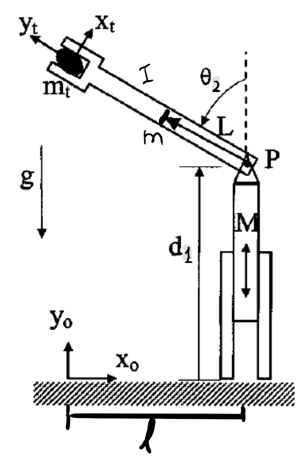

In [2]:
# defining the relevent values and consts of the system:
# for convenience reasons M = m1, m = m2. mt=mt

m1, m2, mt = 0.2, 0.2, 0.7
I = 0.5
l = 0.1
g = 9.81

# model of the ode:

def M_mat(q):
    return np.array([[m1 + m2 + mt, -l*(m2*np.sin(q[1])+2*mt*np.sin(q[1]))], 
                 [-l*(m2*np.sin(q[1])+2*mt*np.sin(q[1])), (l**2)*((4/3)*m2 + 4*mt)]]) 

def C_mat(q, dq):
    return np.array([[0, -l*dq[1]*(2*mt*np.cos(q[1]) + m2*np.cos(q[1]))],
                  [l*dq[1]*(2*mt*np.cos(q[1]) + m2*np.cos(q[1])), -l*dq[0]*(2*mt*np.cos(q[1]) + m2*np.cos(q[1]))]]) 
    
def G_vec(q):
    return g* np.array([m1 + m2 + mt, -l*np.sin(q[1])*(m2+2*mt)])

def model(x, t, u):
    x1 = x[:2] # q
    x2 = x[2:] # dq

    invM = np.linalg.inv(M_mat(x1))
    C = C_mat(x1, x2)
    G = G_vec(x1)
    dx1 = x2
    dx2 = invM.dot(u - C.dot(x2) - G)
    dxdt = np.concatenate((dx1, dx2), axis = 0)

    return dxdt

def direct_kinematics(q):
    return [l-2*l*np.sin(q[1]), q[0] + 2*l*np.cos(q[1])]


In [3]:
#Solve

t = np.linspace(0, 7, 1000)
x0 = np.array([0.3, 0.2, 0, 0]).reshape((2*2,))
u = np.array([(m1 + m2 + mt)*g, 0])

Q = odeint(model, x0, t, args=(u,))
X = np.array([direct_kinematics(q) for q in Q])


## גרפים של מיקומים ומהירויות המפרקים:

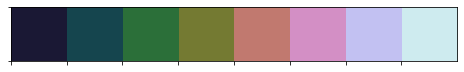

In [4]:
colo = sns.color_palette("cubehelix", 8)
sns.palplot(colo)

In [5]:
# ------ Plot ------
def plot(Q, t):
    sns.set_style('darkgrid')

    f, ax = plt.subplots(2, 2, figsize=(12,8))
    ax[0, 0].plot(t, np.rad2deg(Q[:,1]), color=colo[2])
    ax[0, 0].set_title('Angle $ \\theta _2$', fontsize=18)
    ax[0, 0].set_xlabel('t (sec)')
    ax[0, 0].set_ylabel('$\\theta _2$ (deg)')
    ax[0, 0].set_xlim([0, np.max(t)])

    ax[0, 1].plot(t, Q[:,0], color=colo[-4])
    ax[0, 1].set_title('$d_1$', fontsize=18)
    ax[0, 1].set_xlabel('t (sec)')
    ax[0, 1].set_ylabel('$d_1$ (m)')
    ax[0, 1].set_xlim([0, np.max(t)])

    ax[1, 0].plot(t, Q[:,3], color=colo[2])
    ax[1, 0].set_title('Angolar velocity $\dot{\\theta _2}$', fontsize=18)
    ax[1, 0].set_xlabel('t (sec)')
    ax[1, 0].set_ylabel('$\dot{\\theta _2}$ (rad/sec)')
    ax[1, 0].set_xlim([0, np.max(t)])

    ax[1, 1].plot(t, Q[:,2], color=colo[-4])
    ax[1, 1].set_title('Linear velocity $ \dot{d_1} $', fontsize=18)
    ax[1, 1].set_xlabel('t (sec)')
    ax[1, 1].set_ylabel('v (m/sec)')
    ax[1, 1].set_xlim([0, np.max(t)])
    
    plt.tight_layout()
    #plt.savefig('ex05_ques4.png')
    plt.show()
    plt.close('all')


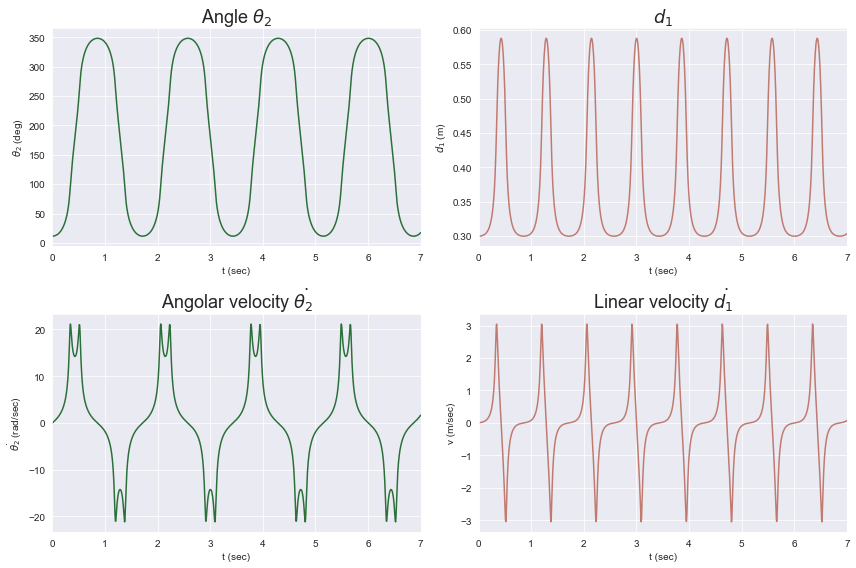

In [6]:
plot(Q, t)

## גרף של מיקום התפסנית לאורך התנועה לעיל:

In [7]:
def plotxy(X):
    plt.plot(X[:,0], X[:,1], color='black')
    plt.plot(X[0, 0], X[0, 1], marker='o', color='g')
    plt.text(X[0, 0]+0.005, X[0, 1], 't = 0 sec')
    plt.plot(X[-1, 0], X[-1, 1], marker='o', color='blue')
    plt.text(X[-1, 0]-0.08, X[-1, 1], 't = 7 sec')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.show()
    plt.close('all')

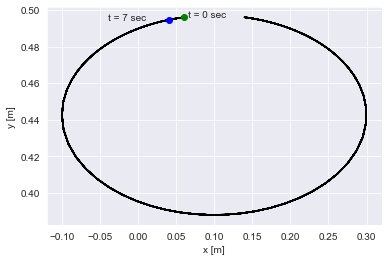

In [8]:
plotxy(X)

In [9]:
from matplotlib import animation

In [10]:
animate = input('create animation? y/n?')

create animation? y/n? n


In [11]:
# Animate

if animate == 'y':
    fig = plt.figure()
    ax = plt.axes(xlim=(-0.2, 0.5), ylim=(0, 0.6))
    ax.set_aspect('equal')
    ax.tick_params(axis='both', bottom=False, top=False, right=False, left=False)
    lines, = ax.plot([], [], lw=2)
    points, = ax.plot([], [], 'ok')
    path, = ax.plot([], [], ':', lw=1)


    def init():
        lines.set_data([], [])
        points.set_data([], [])
        path.set_data([], [])
        return lines, points, path,

    # animation function.  This is called sequentially
    def animate(i):
        q = Q[i,:2]
        p = np.array([[l, 0], [l, q[0]], [l-2*l*np.sin(q[1]), q[0] + 2*l*np.cos(q[1])]]) #, direct_kinematics(q)

        lines.set_data(p[:,0], p[:,1])
        points.set_data(p[:,0], p[:,1])
        path.set_data(X[:i,0], X[:i,1])
        return lines, points, path,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Q.shape[0], interval=20, blit=False)
    anim.save('animation2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


### נתכנן כעת בקר PD
צורת בקר מסוג PD:

$$ \tau = -k_p (\vec{q} - \vec{q_d}) - k_D \dot{q} $$

In [12]:
def PD(q, dq, xg):
    Kp = np.diag([2500, 150]) 
    Kd = np.diag([50, 80]) 
    u = - Kp.dot(q-xg[:2]) - Kd.dot(dq) 
    return u

def model2(x, t, xg):
    x1 = x[:2] # q
    x2 = x[2:] # dq
    u = PD(x1, x2, xg).reshape((2,))
    
    invM = np.linalg.inv(M_mat(x1))
    C = C_mat(x1, x2)
    G = G_vec(x1)
    dx1 = x2
    dx2 = invM.dot(u - C.dot(x2) - G)

    dxdt = np.concatenate((dx1, dx2), axis = 0)

    return dxdt

In [13]:
xg = np.array([0.5, np.pi/2, 0, 0])
Q2 = odeint(model2, x0, t, args=(xg,))
X2 = np.array([direct_kinematics(q) for q in Q2])

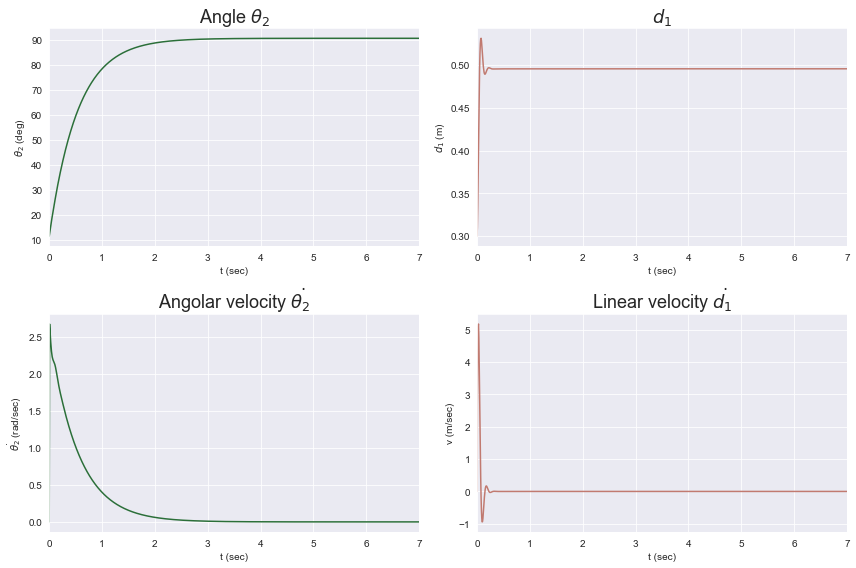

In [14]:
plot(Q2, t)

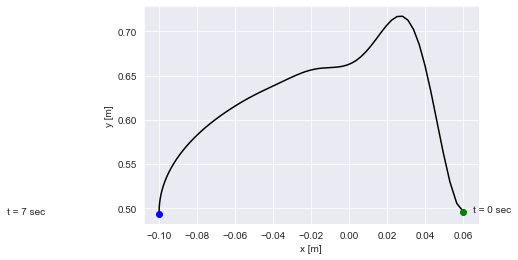

In [15]:
plotxy(X2)

In [16]:
animate = input('animate? y/n')

animate? y/n n


In [17]:
if animate == 'y':
    fig = plt.figure()
    ax = plt.axes(xlim=(-0.2, 0.5), ylim=(0, 0.7))
    ax.set_aspect('equal')
    ax.tick_params(axis='both', bottom=False, top=False, right=False, left=False)
    lines, = ax.plot([], [], lw=2)
    points, = ax.plot([], [], 'ok')
    path, = ax.plot([], [], ':', lw=1)


    def init():
        lines.set_data([], [])
        points.set_data([], [])
        path.set_data([], [])
        return lines, points, path,

    # animation function.  This is called sequentially
    def animate(i):
        q = Q2[i,:2]
        p = np.array([[l, 0], [l, q[0]], [l-2*l*np.sin(q[1]), q[0] + 2*l*np.cos(q[1])]]) #, direct_kinematics(q)

        lines.set_data(p[:,0], p[:,1])
        points.set_data(p[:,0], p[:,1])
        path.set_data(X2[:i,0], X2[:i,1])
        return lines, points, path,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Q.shape[0], interval=20, blit=False)
    anim.save('animation3.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [19]:
from moviepy.editor import *

In [20]:
clip = (VideoFileClip('animation3.mp4'))
clip.write_gif('animation3.gif')

MoviePy - Building file animation3.gif with imageio.
